# **Import the required libraries**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import zipfile
import seaborn as sns
import tensorflow as tf
import shutil
import numpy as np
from PIL import Image
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# **Connecting Colab to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Extract Dataset in Zip form**

In [ ]:
#ekstrak file zip berisi dataset
local_zip = '/content/drive/MyDrive/Capstone/dataset2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

# **Set the path and view the available classes**

In [ ]:
trainpath = '/content/dataset2/train'

# Fungsi untuk mendapatkan label dari folder
def get_labels_from_folder(path):
    # List direktori di dalam folder
    labels = os.listdir(path)
    # Menghapus item yang bukan direktori (jika ada)
    labels = [label for label in labels if os.path.isdir(os.path.join(path, label))]
    return labels

# Mendapatkan dan mencetak label
train_labels = get_labels_from_folder(trainpath)
print("train class:", len(trainpath))
print("Train class labels:", train_labels)

train class: 23
Train class labels: ['papaya', 'grape', 'dragonfruit', 'durian', 'grapefruit', 'orange_mandarine', 'guava', 'rambutan', 'passion_fruit', 'mangosteen', 'banana', 'blackberry', 'mango', 'apple', 'pomegranate', 'avocado', 'raspberry', 'jackfruit', 'pineapple', 'salak', 'cempedak', 'coconut', 'pear']


# **Divide the dataset into training data and test data**

In [ ]:
# Membuat folder untuk train dan test set
train_data = '/content/dataset/train'
test_data = '/content/dataset/test'

os.makedirs(train_data, exist_ok=True)
os.makedirs(test_data, exist_ok=True)

# Membuat subfolder untuk setiap label di train dan test set
for label in train_labels:
    os.makedirs(os.path.join(train_data, label), exist_ok=True)
    os.makedirs(os.path.join(test_data, label), exist_ok=True)

# Memindahkan file ke train dan test set
for label in train_labels:
    files = os.listdir(os.path.join(trainpath, label))
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    for file in train_files:
        shutil.move(os.path.join(trainpath, label, file), os.path.join(train_data, label, file))

    for file in test_files:
        shutil.move(os.path.join(trainpath, label, file), os.path.join(test_data, label, file))

print("Dataset split into train and test sets successfully.")

Dataset split into train and test sets successfully.


In [ ]:
# Menghitung total file di train dan test set
total_train_files = sum([len(files) for _, _, files in os.walk(train_data)])
total_test_files = sum([len(files) for _, _, files in os.walk(test_data)])

print(f"Total files in train set: {total_train_files}")
print(f"Total files in test set: {total_test_files}")

Total files in train set: 7360
Total files in test set: 1840


# **Data Preprocessing**

### **ImageDataGenerator for image augmentation and normalization**

In [ ]:
# Preprocessing data menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

### **Use flow_from_directory to load images from a directory**

In [ ]:
# Menggunakan flow_from_directory untuk memuat gambar dari direktori
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Menggunakan categorical karena mengeluarkan output softmax
)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7360 images belonging to 23 classes.
Found 1840 images belonging to 23 classes.


# **Building CNN Model**

### **Using pre-trained models and additional custom layers**

In [ ]:
# Load MobileNetV2 tanpa lapisan top (head)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Tambahkan lapisan custom di atas model pre-trained
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Mengatur base model sebagai non-trainable (freeze weights)
base_model.trainable = False

### **Compile the model using adam optimizer**

In [ ]:
# Kompilasi model
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 23)                2967      
                                                                 
Total params: 2424919 (9.25 MB)
Trainable params: 1669

# **Training Model**

In [ ]:
# Latih model
epochs = 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/50
230/230 [==============================] - 108s 459ms/step - loss: 3.1078 - accuracy: 0.4837 - val_loss: 1.6313 - val_accuracy: 0.7902
Epoch 2/50
230/230 [==============================] - 103s 450ms/step - loss: 1.7384 - accuracy: 0.6806 - val_loss: 1.2005 - val_accuracy: 0.8120
Epoch 3/50
230/230 [==============================] - 103s 448ms/step - loss: 1.4288 - accuracy: 0.7185 - val_loss: 1.0482 - val_accuracy: 0.8179
Epoch 4/50
230/230 [==============================] - 102s 443ms/step - loss: 1.3405 - accuracy: 0.7238 - val_loss: 0.9977 - val_accuracy: 0.8337
Epoch 5/50
230/230 [==============================] - 105s 455ms/step - loss: 1.2891 - accuracy: 0.7265 - val_loss: 0.9810 - val_accuracy: 0.8272
Epoch 6/50
230/230 [==============================] - 103s 449ms/step - loss: 1.2512 - accuracy: 0.7346 - val_loss: 0.9458 - val_accuracy: 0.8321
Epoch 7/50
230/230 [==============================] - 102s 444ms/step - loss: 1.2326 - accuracy: 0.7321 - val_loss: 0.9249 -

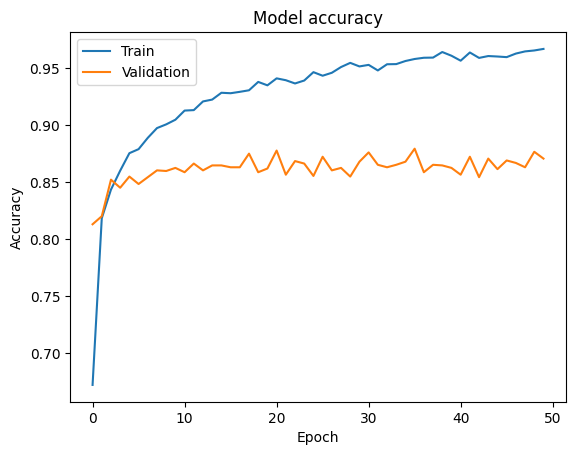

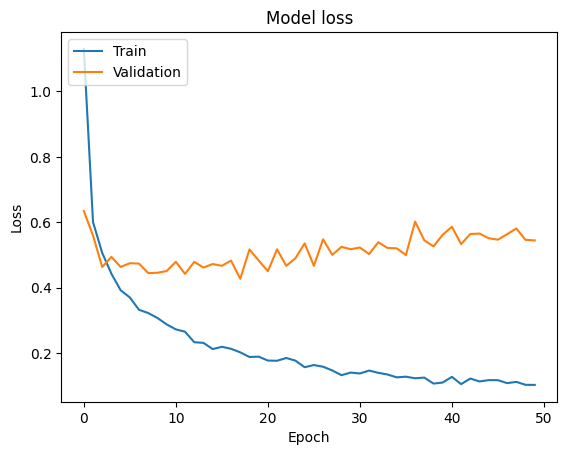

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Menyimpan model ke file .h5
model.save('model_fix.h5')

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

58/58 [==============================] - 4s 71ms/step - loss: 0.5446 - accuracy: 0.8707
Test accuracy: 0.87
